In [1]:
%cd ..

/home/tianshu/prediction


In [2]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from jax import numpy as jnp
from jax import vmap

from forecast import Dataset, Results

In [3]:
ds = Dataset("data.npz", if_data="if.npz", offset=1000. * 1000.)
results = Results(
    ds, base_dir="results", manifest="results/manifest.json",
    baseline_key="Lr8")

  0%|          | 0/31 [00:00<?, ?it/s]

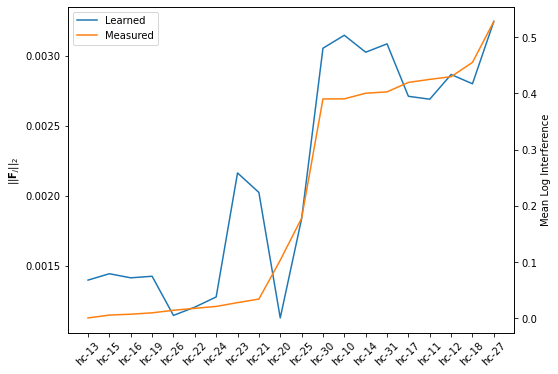

In [4]:
# Interference Magnitude
# L2 matrix norm is max_{m_i, m_k} m_i^TF_jm_k, i.e. the maximum possible
# interference achieved by a pair of modules in our embedding space.

def _interference_magnitude():

    def spectral_norm(v_s, v_g):
        return jnp.linalg.norm(jnp.matmul(v_s, v_g.T))

    vvv = vmap(vmap(vmap(spectral_norm)))
    res = np.load("results/Is1/0.9.npz")
    norms = jnp.mean(vvv(res["V_s"], res["V_g"]), axis=(0, 1))

    df = pd.read_csv("data/if.csv")
    mean_interference = np.array(df.groupby("runtime")["diff"].mean())

    order = np.argsort(mean_interference)

    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
    ln1 = ax1.plot(norms[order], label="Learned")
    ax1.set_xticks(np.arange(len(ds.runtimes)))
    ax1.set_xticklabels(ds.runtimes[order], rotation=45)
    ax1.set_ylabel("$||\mathbf{F}_j||_2$")

    ax2 = ax1.twinx()
    ln2 = ax2.plot(mean_interference[order], color='C1', label="Measured")
    ax2.set_ylabel("Mean Log Interference")

    ax1.legend(ln1 + ln2, [l.get_label() for l in ln1 + ln2])
    fig.savefig("figures/interference_interp.png", dpi=300)

_interference_magnitude()

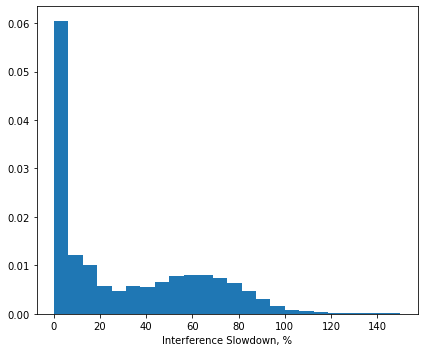

In [5]:
# Interference Histogram

def _interference_histogram():
    df = pd.read_csv("data/if.csv")
    fig, axs = plt.subplots(1, 1, figsize=(6, 5))
    axs.hist(
        100 * (np.exp(df["diff"]) - 1),
        bins=np.linspace(0, 150, 25), density=True)
    axs.set_xlabel("Interference Slowdown, %")
    fig.tight_layout()
    fig.savefig("figures/interference_hist.png", dpi=300)

_interference_histogram()

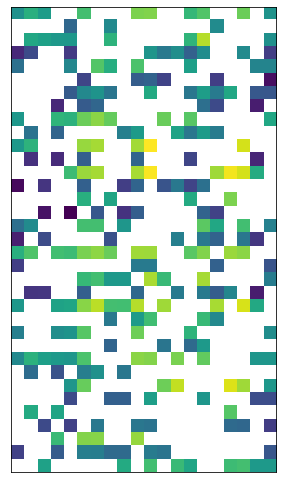

In [6]:
# Matrix Completion

def _matrix_completion():
    ds = Dataset("data/data.npz", if_data="data/if.npz", offset=1000. * 1000.)

    mat = ds.matrix[30:65]
    random_mask = np.random.rand(*mat.shape) > 0.4
    mat = np.ma.masked_where(random_mask == 1, mat)
    cmap = matplotlib.cm.viridis.copy()
    cmap.set_bad(color='white')

    fig, axs = plt.subplots(1, 1, figsize=(mat.shape[1] / 5, mat.shape[0] / 5))
    axs.imshow(mat, cmap=cmap)
    axs.set_xticks([])
    axs.set_yticks([])
    fig.tight_layout()
    fig.savefig("figures/matrix_completion.png", dpi=300, bbox_inches='tight')

_matrix_completion()

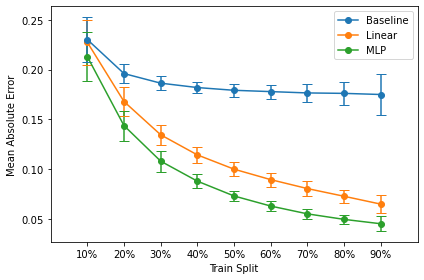

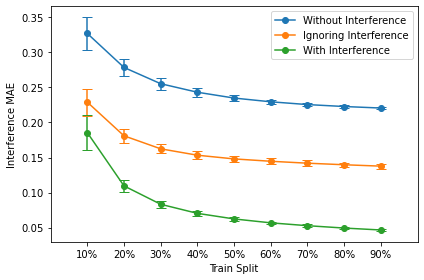

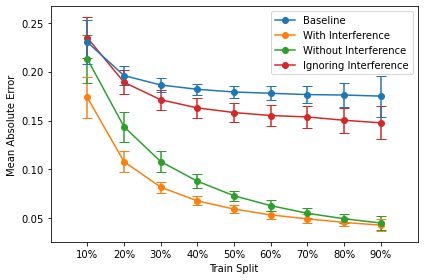

In [7]:
# Comparisons

def _method_comparisons():

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Lr64", "Er64"], ax=axs, boxplot=False, baseline=True,
        key="error", labels={"Lr64": "Linear", "Er64": "MLP"})
    fig.tight_layout()
    fig.savefig("figures/non-interference.png", dpi=300)

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Er64", "ignore", "Is1"], ax=axs, boxplot=False,
        baseline=False, key="interference", labels={
            "Er64": "Without Interference",
            "ignore": "Ignoring Interference",
            "Is1": "With Interference"})
    axs.set_ylabel("Interference MAE")
    fig.tight_layout()
    fig.savefig("figures/interference.png", dpi=300)

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Is1", "Er64", "ignore"], ax=axs, boxplot=False,
        baseline=True, key="error", labels={
            "Er64": "Without Interference", "Is1": "With Interference",
            "ignore": "Ignoring Interference"})
    fig.tight_layout()
    fig.savefig("figures/interference_error.png", dpi=300)


_method_comparisons()

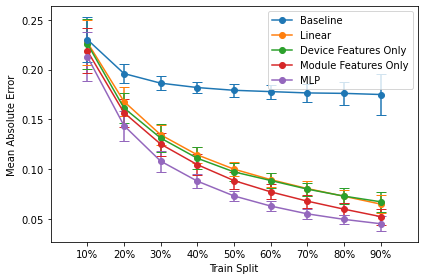

In [14]:
# Ablation: Input Features

def _ablation_features():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Lr64", "device_only", "module_only", "Er64"],
        ax=ax, baseline=True, key="error", boxplot=False, labels={
            "Lr64": "Linear",
            "Er64": "MLP"
        })
    fig.tight_layout()
    fig.savefig("figures/feature_ablation.png", dpi=300)

_ablation_features()

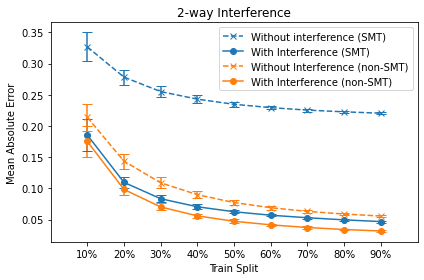

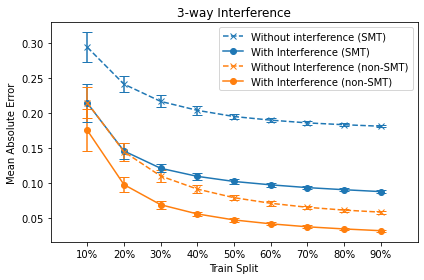

In [8]:
# 2-way, different datasets

def _interference_comparisons():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Er64", "Is1", "e.if.mc", "if.mc"], ax=ax, baseline=False,
        boxplot=False, key="interference", fmt=['x--', 'o-', 'x--', 'o-'],
        colors=['C0', 'C0', 'C1', 'C1'], labels={
            "Er64": "Without interference (SMT)",
            "Is1": "With Interference (SMT)",
            "e.if.mc": "Without Interference (non-SMT)",
            "if.mc": "With Interference (non-SMT)"
        })
    ax.set_title("2-way Interference")
    fig.tight_layout()
    fig.savefig("figures/interference_2way.png", dpi=300)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["e.if3", "if3", "e.if3.mc", "if3.mc"], ax=ax, baseline=False,
        boxplot=False, key="interference", fmt=['x--', 'o-', 'x--', 'o-'],
        colors=['C0', 'C0', 'C1', 'C1'], labels={
            "e.if3": "Without interference (SMT)",
            "if3": "With Interference (SMT)",
            "e.if3.mc": "Without Interference (non-SMT)",
            "if3.mc": "With Interference (non-SMT)"
        })

    ax.set_title("3-way Interference")

    fig.tight_layout()
    fig.savefig("figures/interference_3way.png", dpi=300)

_interference_comparisons()

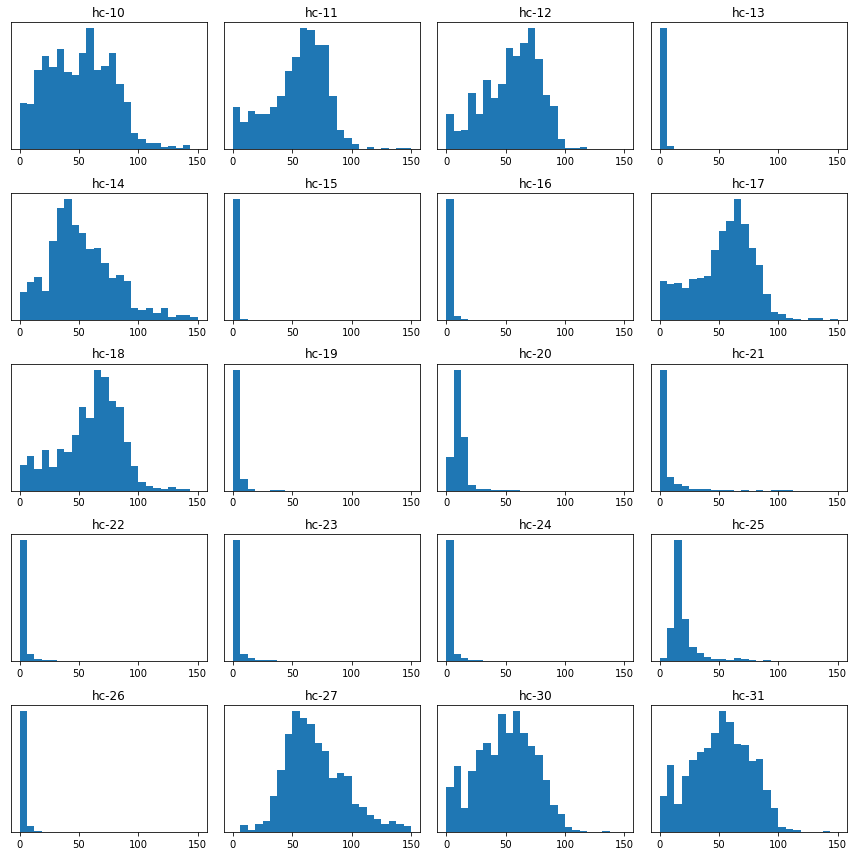

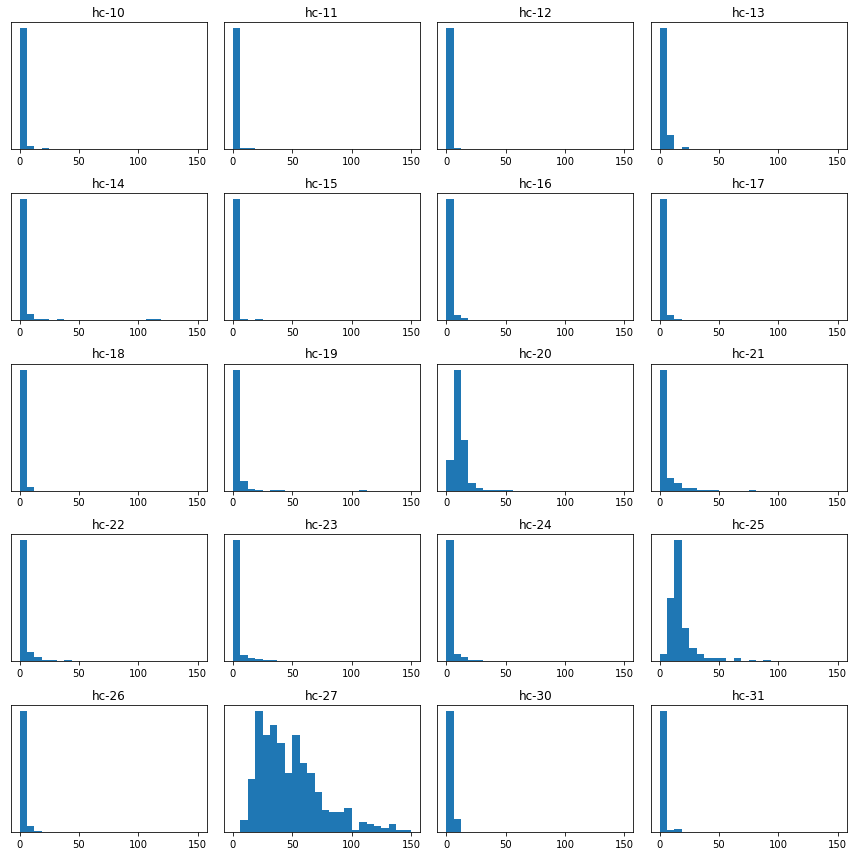

In [9]:
def _interference_runtime(data, out):
    fig, axs = plt.subplots(5, 4, figsize=(12, 12))
    df = pd.read_csv(data)

    for rt, ax in zip(ds.runtimes, axs.reshape(-1)):
        ax.hist(
            100 * (np.exp(df[df["runtime"] == rt]["diff"]) - 1),
            np.linspace(0, 150, 25), density=True)
        ax.set_yticks([])
        ax.set_title(rt)

    fig.tight_layout()
    fig.savefig(out, dpi=300, bbox_inches='tight')

_interference_runtime(
    "data/if.csv", "figures/interference_runtime.png")
_interference_runtime(
    "data/if.mc.csv", "figures/interference_multicore.png")